# Exercise 3: Convolutional Neural Networks

Gruppo Stocafisici: Edoardo Antonaci, Angelica Foroni, Francesco Mazza, Leonardo Salicari.

1. Experiment with different architectures (which was left as an open point when “NCONV”
variable was introduced), in particular try at least another version where only one
convolutional layer is introduced instead of two, and where any number of dense layers may
be used, with the global constraint of using a network with at most 600 trainable parameters.
The filter length in the second convolutional layer may be shorter.
Is the number of parameters scaling more quickly by adding Dense layers or Conv1D
layers?
Check which configuration works better by comparing the performances quantitatively.
2. Visualize the “confusion matrix” (look for similar examples in the material available or by
googling)
3. With two convolutional layers, plot also the weights of the second layer and try to see if
regularization may improve the performances by varying the parameter lambda of the L1 or
of the L2 regularization; see lambda in eqs.(43) and (52) in the review. There is also a mixed
version (l1_l2?) that can be tried. Is any value of lambda good? Is there any intermediate
value where the performances of the network are better? Is there any improvement in the
visualization and understanding of the weights in the filters? Note that the regularization we
introduced acts on the w’s, not on the biases. One can also try the equivalent procedure for
biases or for the output of the relu units (see Keras doc.), if there is any reason for
suspecting that it may help. In our case, the logic was to let the weights of the filters go to
zero if not needed, hence that kind of regularization was selected.
4. By reducing the signal-to-noise ratio, namely the amplitude of the external signal in the data
(A) with respect to the step typical size of the jump process, check where the network starts
to fail discriminating the categories.

### Loading dataset


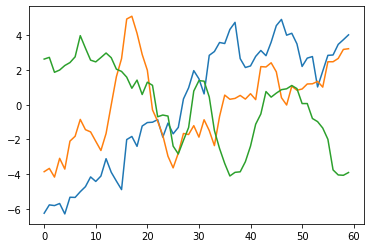

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Version compatible with git folder
name = '_ts_L60_Z12_A12_DX50_bias5_N10000.csv'
xname = 'DATA/x' + name
yname = 'DATA/y' + name

# Other version
#name = '_ts_L60_Z12_A12_DX50_bias5_N10000.csv'
#xname = fname
#yname = 'y' + name

# Dataset
x = np.loadtxt(xname, delimiter=',', dtype=float)
N = x.shape[0]
L = x.shape[1]

# Labels
categ = np.loadtxt(yname, delimiter=',', dtype=int)
n_class = 3
y = np.zeros((N, n_class ))
for i in range(N):
    y[i][categ[i]] = 1.

# Removing avg and scaling data
x_avg = np.mean(x, axis=1).reshape(N,1) # average over sample (i.e. over rows)
x = (x - x_avg)/100 # one line to remove avg and scale; faster than a for loop
    
# Training and Validation
# Note, these are view, not copies
train_frac = .8
N_train = int(N*train_frac)
x_train = x[0:N_train,:]
y_train = y[0:N_train,:]
x_val = x[N_train:,:]
y_val = y[N_train:,:]

# Plotting some data
for k in range(3):
    plt.plot(x_train[k])
    
# Reshape for Keras
# Hence adding an extra dim wich correspond to the depth 
x_train = x_train.reshape(x_train.shape[0],L,1)
x_val = x_val.reshape(x_val.shape[0],L,1)

input_size = (L,1)

## 1: CNN with different topologies

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils.layer_utils import count_params # for count number of parameters
from keras.losses import categorical_crossentropy
from keras.regularizers import l1, l2, l1_l2
from keras import initializers
from keras import optimizers

def create_model(NCONV=1, n_dense_layers=1, kernel_size_diff=1, summary=False, reg=l1(0.1)):
    ''' 
    Creates a CNN with different topologies by changing NCONV 
    Returns the model and the number of trainable parameters
    
    n_dense_layers = number of dense layers in the CNN
    kernel_size_diff = (kernel_size first Conv layer) - (kernel_size second Conv layer)
    summary = print model.summary()
    
    NCONV == 1:
        From baiesi lecture
        Conv -> AvgPadding -> Conv -> Fattern -> Dense*(n_dense_layers) -> Dense (output)
    NCONV == 2: 
        Only one Conv layer
        Conv -> AvgPadding -> Fattern -> Dense*(n_dense_layers) -> Dense (output)
        
    '''
    if n_dense_layers < 1:
        raise('n_dense_layer must be int and >= 1')
        
    # Used to initialize kernel 
    init = initializers.RandomNormal(mean = 0,
                                    stddev = .05,
                                    seed = 12345) # reproducibility in training
    model = Sequential()

    if NCONV == 1:
        model.add( Conv1D(filters=5,
                          kernel_size = 11,                              
                          kernel_initializer = init,
                          kernel_regularizer = reg,
                          activation = 'relu',
                          input_shape = input_size
                         ) )
        model.add( AveragePooling1D(5) ) # max pooling windows' size
        model.add( Conv1D(filters=5, 
                          kernel_size = 11 - kernel_size_diff, 
                          activation = 'relu',) )
        model.add( Flatten() )
        for _ in range(n_dense_layers): # variable number of layers
            model.add( Dense(10, activation='relu') )
        model.add( Dropout(0.2) )
        
    elif NCONV == 2:
        model.add( Conv1D(filters=5,
                          kernel_size = 11,                              
                          kernel_initializer = init,
                          kernel_regularizer = reg,
                          activation = 'relu',
                          input_shape = input_size
                         ) )
        model.add( AveragePooling1D(5) ) # max pooling windows' size
        model.add( Flatten() )
        for _ in range(n_dense_layers): # variable number of layers
            model.add( Dense(10, activation='relu') )
        model.add( Dropout(0.2) )
    else:
        raise('NCONV must be an int: 1 or 2')
        
    # Output layer
    model.add(Dense(n_class, activation='softmax')) 
    
    # print model's details
    if summary: print(model.summary())
    # Number of trainable parameters
    trainable_count = count_params(model.trainable_weights)
    
    # Compiling model
    opt = optimizers.Nadam()
    model.compile( loss = categorical_crossentropy,
              optimizer = opt,
              metrics = ['accuracy'])
    
    return (model, trainable_count)

### Training and test performance

 Is the number of parameters scaling more quickly by adding Dense layers or Conv1D layers?

Text(0, 0.5, '# of trainable parameters')

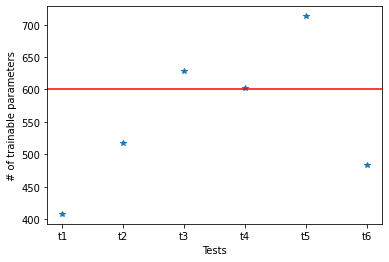

In [10]:
# Define dicts to test different topologies
# t1 == test 1
t1 = dict(NCONV = 1, n_dense_layers = 1, kernel_size_diff = 1)
t2 = dict(NCONV = 1, n_dense_layers = 2, kernel_size_diff = 1)
t3 = dict(NCONV = 1, n_dense_layers = 3, kernel_size_diff = 1)
t4 = dict(NCONV = 2, n_dense_layers = 1, kernel_size_diff = 1)
t5 = dict(NCONV = 2, n_dense_layers = 2, kernel_size_diff = 1)
t6 = dict(NCONV = 1, n_dense_layers = 1, kernel_size_diff = 4)

# Array with tests
tests = [t1,t2,t3,t4,t5,t6]
# Array with names for plotting porpuses
tests_plot = ['t1','t2','t3','t4','t5','t6']
# Array to save # of parameters
params = [0] * len(tests)

for idx,t in enumerate(tests):
    _, params[idx] = create_model(**t, summary=False) # **t is the syntax to 'unpack' values from dict
    
# Visualising number of parameters
plt.close()
plt.plot(tests_plot, params, '*')
plt.axhline(y=600, color='red') # line of 600 parameters
plt.xlabel('Tests')
plt.ylabel('# of trainable parameters')

#### Comment
It's seems like that removing a `Conv1D` layer the number of trainable parameters grows. Looking at the summary of the models, this apparent contradiction seems to be solve by the fact that in the case of 2 convolutional layers the `output size` of the layer's output is smaller compared to the model with only one convolutional layer.

Than, the fully connected layers (the `Dense` one) han a number of trainable parameters related to the number of weights and biases which grows quickly with the `output size` of the previous layer. Hence, the one-convolutional-layer model has more parameters due to its bigger output given to the fully connected layer.

For more info, use the option `summary=True` in the `create_model()` function's call.

### Performance comparison
It'll be trained models relative to configurations `t2`, `t4` and `t6`


In [11]:
model2, _ = create_model(**t2)
model4, _ = create_model(**t4)
model6, _ = create_model(**t6)

# Training
batch_size = 250
epochs = 125

fit2 = model2.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose = 2,
                shuffle = True)
fit4 = model4.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose = 2,
                shuffle = True)
fit6 = model6.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose = 2,
                shuffle = True)

Train on 8000 samples, validate on 2000 samples
Epoch 1/125
 - 1s - loss: 1.2341 - accuracy: 0.3849 - val_loss: 1.1485 - val_accuracy: 0.4260
Epoch 2/125
 - 0s - loss: 1.1160 - accuracy: 0.4426 - val_loss: 1.0960 - val_accuracy: 0.4630
Epoch 3/125
 - 0s - loss: 1.0811 - accuracy: 0.4676 - val_loss: 1.0549 - val_accuracy: 0.5170
Epoch 4/125
 - 0s - loss: 1.0202 - accuracy: 0.5403 - val_loss: 0.9786 - val_accuracy: 0.5850
Epoch 5/125
 - 0s - loss: 0.9609 - accuracy: 0.5679 - val_loss: 0.9254 - val_accuracy: 0.6000
Epoch 6/125
 - 0s - loss: 0.8941 - accuracy: 0.6099 - val_loss: 0.8740 - val_accuracy: 0.6300
Epoch 7/125
 - 0s - loss: 0.8605 - accuracy: 0.6235 - val_loss: 0.8214 - val_accuracy: 0.6535
Epoch 8/125
 - 0s - loss: 0.8282 - accuracy: 0.6359 - val_loss: 0.7995 - val_accuracy: 0.6530
Epoch 9/125
 - 0s - loss: 0.8010 - accuracy: 0.6566 - val_loss: 0.7798 - val_accuracy: 0.6705
Epoch 10/125
 - 0s - loss: 0.8097 - accuracy: 0.6555 - val_loss: 0.7878 - val_accuracy: 0.6835
Epoch 11/12

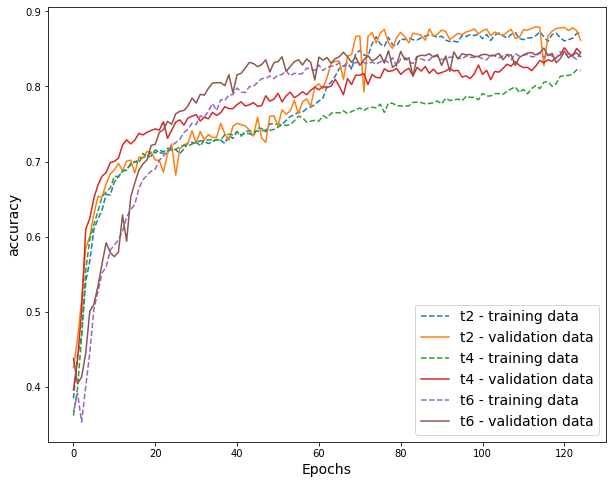

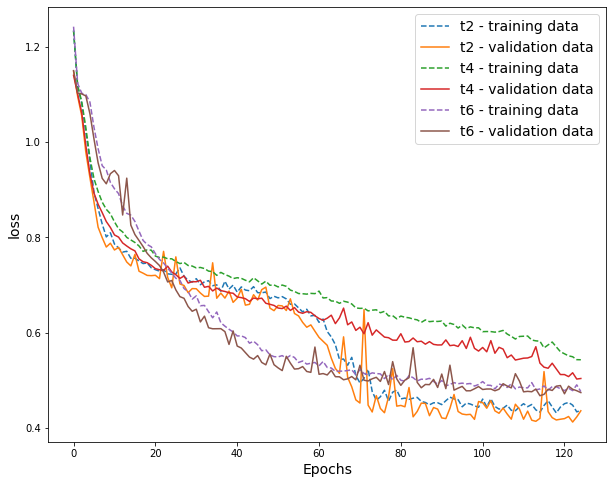

In [12]:
# Grafical comparison

fits = [fit2,fit4,fit6]

plt.close()

# Accuracy
plt.figure(figsize=(10,8))
for fit, test in zip(fits,tests_plot[1::2]):
    
    plt.plot(fit.history['accuracy'], '--',
            label = test + ' - training data')
    
    plt.plot(fit.history['val_accuracy'],
            label = test + ' - validation data') 

fontsize = 14
plt.ylabel('accuracy', fontsize=fontsize)
plt.xlabel('Epochs', fontsize=fontsize)
plt.legend(loc='lower right', fontsize=fontsize)    
plt.show()

# Loss
plt.figure(figsize=(10,8))
for fit, test in zip(fits,tests_plot[1::2]):
    
    plt.plot(fit.history['loss'], '--',
            label = test + ' - training data')
    
    plt.plot(fit.history['val_loss'],
            label = test + ' - validation data') 

fontsize = 14
plt.ylabel('loss', fontsize=fontsize)
plt.xlabel('Epochs', fontsize=fontsize)
plt.legend(loc='upper right', fontsize=fontsize)    
plt.show()

## 2: Confusion Matrix

As it can be seen from the [relative documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), the `sklearn.metrics.confusion_matrix` function evaluates classification accuracy by computing the confusion matrix with each row corresponding to the true class, and each column corresponding to the predected one. Notice that [Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix) and other references may use different convention for axes.

By definition, entry $C_{ij}$ in a confusion matrix $C$ is the number of observations actually in group $i$, but predicted to be in group $j$. Therefore, the diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

We compute the confusion matrix for the model2, which was the one with the best performance.

In [13]:
from sklearn.metrics import confusion_matrix

# Uncomment to have a look at the test (val) data one more time:
#print('x, of shape {}: \n'.format(x_val.shape), x_val, '\n')
#print('y, of shape {}: \n'.format(y.shape), y_val, '\n')

y_pred = model2.predict(x_val, batch_size = batch_size)
print('The predicted values are:\n', y_pred)

The predicted values are:
 [[0.00134454 0.02577856 0.9728769 ]
 [0.4155273  0.23224315 0.35222957]
 [0.10147379 0.8791063  0.0194199 ]
 ...
 [0.07600173 0.9207787  0.00321955]
 [0.00412337 0.03213748 0.96373916]
 [0.85288954 0.1125566  0.0345539 ]]


In order to compute the confusion matrix, we feed to the confusion_matrix function the index of the maximum value for each row, both for the true labels and for the predicted ones. That index corresponds, moreover, to the wanted category (0 = no signal, 1 = positive signal, 2 = negative signal)

In [14]:
conf_mat = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print(conf_mat)

[[578  30  59]
 [ 52 531  83]
 [ 42  11 614]]


Let's do a rapid check: we compute the accuracy of the model as given by the confusion matrix, and visually compare it to the one plotted previously. 

In [15]:
# Sum the element on the diagonal
sum_diag = np.sum(np.diag(conf_mat)) 
# Sum the offdiagonal terms
sum_offd = np.sum(np.extract(1-np.eye(3), conf_mat))

total_n = sum_diag + sum_offd
# Check if it equals the length of y_val (as it should be):
# total_n == len(y_val)

# Computing and printing the accuracy
print('The percentage of corrected categorized data is {} %'.format(100*sum_diag/total_n) )

The percentage of corrected categorized data is 86.15 %


The result is, therefore, qualitatively consistent. 

Let's plot the confusion matrix:

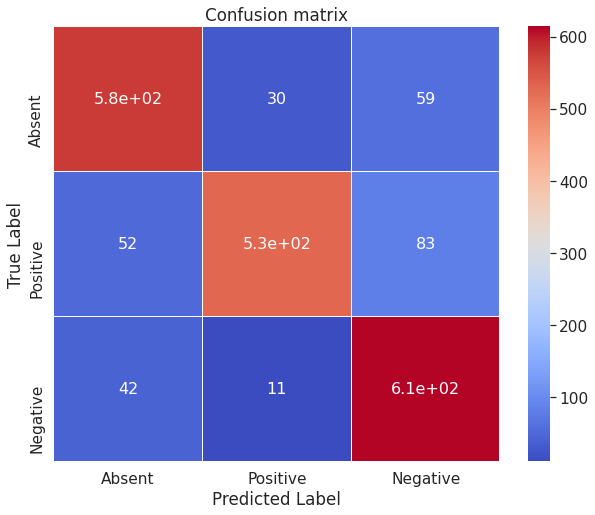

In [16]:
import seaborn as sns
import pandas as pd

# Feed the confusion matrix into a pandas dataframe, to ease the labeling process in the plot
df_cm = pd.DataFrame(conf_mat, columns = ['Absent', 'Positive', 'Negative'],
                    index = ['Absent', 'Positive', 'Negative'])

plt.figure(figsize=(10,8))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="coolwarm",
           linewidths=.5)
plt.title("Confusion matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

## 3. Regularization
With two convolutional layers, plot also the weights of the second layer and try to see if regularization may improve the performances by varying the parameter lambda of the L1 or of the L2 regularization; Is any value of lambda good? Is there any intermediate value where the performances of the network are better? Is there any improvement in the visualization and understanding of the weights in the filters? 

In [17]:
def create_regmodel(NCONV=2, n_dense_layers=1, kernel_size_diff=1, summary=False, reg=regularizers.l1(0.1)):

    if n_dense_layers < 1:
        raise('n_dense_layer must be int and >= 1')
        
    # Used to initialize kernel 
    init = initializers.RandomNormal(mean = 0,
                                    stddev = .05,
                                    seed = 12345)
    model = Sequential()
    model.add( Conv1D(filters=5,
                      kernel_size = 11,                              
                      kernel_initializer = init,
                      kernel_regularizer = reg,
                      activation = 'relu',
                      input_shape = input_size
                     ) )
    model.add( AveragePooling1D(5) ) # max pooling windows' size
    model.add( Flatten() )
    for _ in range(n_dense_layers): # variable number of layers
        model.add( Dense(10, activation='relu') )
    model.add( Dropout(0.2) )
    
    # Output layer
    model.add(Dense(n_class, activation='softmax')) 
    
    # print model's details
    if summary: print(model.summary())
    # Number of trainable parameters
    trainable_count = count_params(model.trainable_weights)
    
    # Compiling model
    opt = optimizers.Nadam()
    model.compile( loss = categorical_crossentropy,
              optimizer = opt,
              metrics = ['accuracy'])
    
    return (model, trainable_count)

In [23]:
# import regularizers
from keras.regularizers import l1, l2, l1_l2
# instantiate regularizer
reg11 = l1(0.0001)
reg12 = l1(0.001)
reg13 = l1(0.01)
reg21 = l2(0.0001)
reg22 = l2(0.001)
reg23 = l2(0.01)
reg3 = l1_l2(0.01,0.001)

model_l1_1, _ = create_model(**t4,reg=reg11)
model_l1_2, _ = create_model(**t4,reg=reg12)
model_l1_3, _ = create_model(**t4,reg=reg13)
model_l2_1, _ = create_model(**t4,reg=reg21)
model_l2_2, _ = create_model(**t4,reg=reg22)
model_l2_3, _ = create_model(**t4,reg=reg23)
model_l1_l2, _ = create_model(**t4,reg=reg3)

#### Training various models

In [19]:
# retrieve weights from the second hidden layer
fits = []
model_list=[model_l1_1,model_l1_2,model_l1_3,model_l2_1,model_l2_2,model_l2_3, model_l1_l2]
for model in model_list:
    fits.append(model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
               validation_data=(x_val,y_val),
                verbose = 2,
                shuffle = True))


Train on 8000 samples, validate on 2000 samples
Epoch 1/125
 - 1s - loss: 1.0911 - accuracy: 0.3639 - val_loss: 1.0674 - val_accuracy: 0.4560
Epoch 2/125
 - 0s - loss: 1.0449 - accuracy: 0.4696 - val_loss: 1.0111 - val_accuracy: 0.5465
Epoch 3/125
 - 0s - loss: 0.9794 - accuracy: 0.5558 - val_loss: 0.9387 - val_accuracy: 0.5910
Epoch 4/125
 - 0s - loss: 0.8965 - accuracy: 0.6110 - val_loss: 0.8575 - val_accuracy: 0.6480
Epoch 5/125
 - 0s - loss: 0.8098 - accuracy: 0.6622 - val_loss: 0.7712 - val_accuracy: 0.7110
Epoch 6/125
 - 0s - loss: 0.7306 - accuracy: 0.7051 - val_loss: 0.6842 - val_accuracy: 0.7610
Epoch 7/125
 - 0s - loss: 0.6547 - accuracy: 0.7459 - val_loss: 0.6647 - val_accuracy: 0.7730
Epoch 8/125
 - 0s - loss: 0.6029 - accuracy: 0.7682 - val_loss: 0.5686 - val_accuracy: 0.7975
Epoch 9/125
 - 0s - loss: 0.5589 - accuracy: 0.7855 - val_loss: 0.5312 - val_accuracy: 0.8080
Epoch 10/125
 - 0s - loss: 0.5246 - accuracy: 0.8029 - val_loss: 0.5061 - val_accuracy: 0.8220
Epoch 11/12

#### Visualizing Weights of the second Conv1D layer

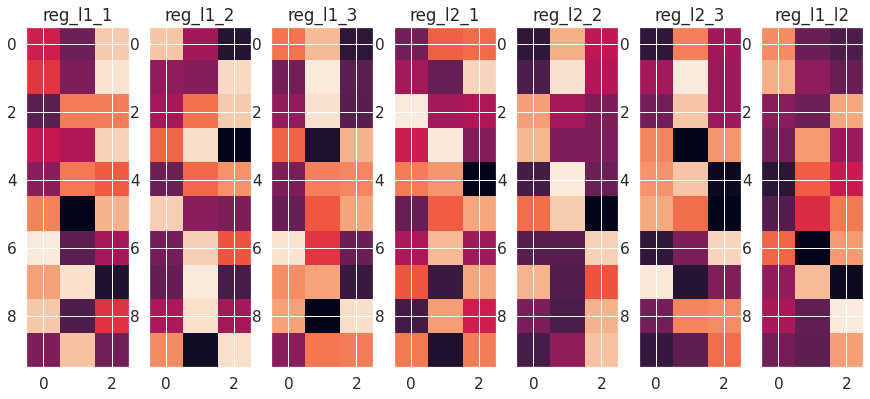

In [25]:
fig, ax = plt.subplots(1,7,figsize=(15,7))
ax_dict={}
ax_dict = {'reg_l1_1': ax[0], 'reg_l1_2': ax[1], 'reg_l1_3': ax[2], 'reg_l2_1': ax[3], 'reg_l2_2': ax[4],
          'reg_l2_3': ax[5], 'reg_l1_l2': ax[6]}

#Setting names
for key in ax_dict:
    ax_dict[key].set_title(key)
    
for model, reg in zip(model_list, ax_dict.keys()):    
    filters, biases = model.layers[-1].get_weights()
    ff = pd.DataFrame(filters)
    ax_dict[reg].imshow(ff)
    #sns.set(font_scale=1.4) # for label size
    #sns.heatmap(ff, annot=True, annot_kws={"size": 16}, cmap="GnBu",
          # linewidths=.5)

plt.show()


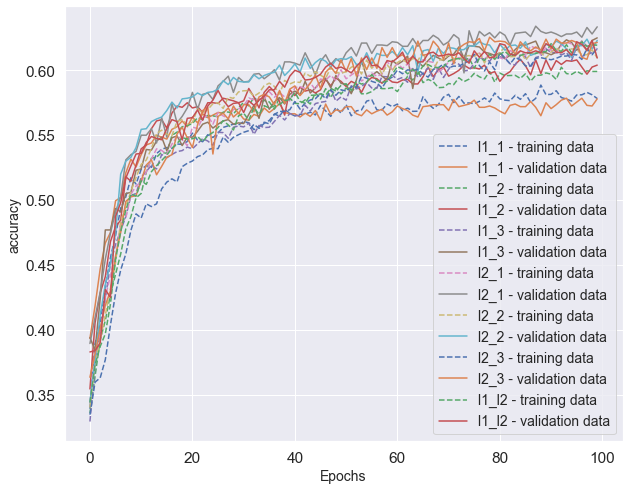

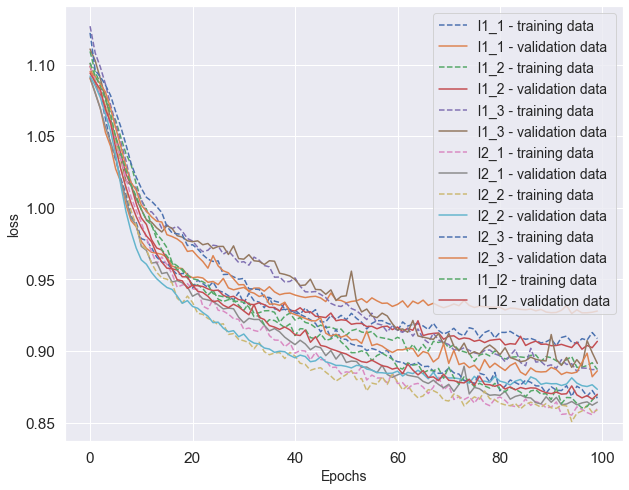

In [79]:
reg=['l1_1','l1_2','l1_3','l2_1','l2_2','l2_3','l1_l2']
# Accuracy
plt.figure(figsize=(10,8))
for fit ,test in zip(fits,reg):
    
    plt.plot(fit.history['accuracy'], '--',
            label = test + ' - training data')
    
    plt.plot(fit.history['val_accuracy'],
            label = test + ' - validation data') 

fontsize = 14
plt.ylabel('accuracy', fontsize=fontsize)
plt.xlabel('Epochs', fontsize=fontsize)
plt.legend(loc='lower right', fontsize=fontsize)    
plt.show()

# Loss
plt.figure(figsize=(10,8))
for fit, test in zip(fits,reg):
    
    plt.plot(fit.history['loss'], '--',
            label = test + ' - training data')
    
    plt.plot(fit.history['val_loss'],
            label = test + ' - validation data') 

fontsize = 14
plt.ylabel('loss', fontsize=fontsize)
plt.xlabel('Epochs', fontsize=fontsize)
plt.legend(loc='upper right', fontsize=fontsize)    
plt.show()